In [196]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torchvision import transforms
from PIL import Image
from torch import optim
from torch.utils.data import Dataset, DataLoader
from glob import glob
import os
from torchsummary import summary
import time
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [197]:
class DogCatDataset(Dataset):
    LABEL_DICT = {
        'cats': 0,
        'dogs': 1
    }

    def __init__(self, folder_path, aug=None):
        super().__init__()

        self.x = []
        self.y = []
        self.aug = []

        self.img_transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.PILToTensor(),
        ])

        self.aug = aug

        for label, value in DogCatDataset.LABEL_DICT.items():
            path = os.path.join(folder_path, label, '*.jpg')
            files = glob(path)

            self.x.extend(files)
            self.y.extend([value] * len(files))
            
        combined = list(zip(self.x, self.y))
        random.shuffle(combined)
        self.x[:], self.y[:] = zip(*combined)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = Image.open(self.x[idx]).convert('RGB')
        y = self.y[idx]

        x = self.img_transformer(x).float().to(device) / 255

        return x, torch.tensor(y, dtype=torch.float32)

In [198]:
trn_dataset = DogCatDataset("./cats_and_dogs_classification/training_set")
val_dataset = DogCatDataset("./cats_and_dogs_classification/test_set")

val_dataset.x = val_dataset.x
val_dataset.y = val_dataset.y

trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [199]:
class Network(nn.Module):
    @staticmethod
    def conv_layer(cin, cout, ks=3, stride=1, padding=0, pool_size=2):
        return nn.Sequential(
            nn.Conv2d(cin, cout, kernel_size=ks, stride=stride, padding=padding),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.MaxPool2d(pool_size)
        )

    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            self.conv_layer(3, 16, pool_size=4),
            self.conv_layer(16, 32, pool_size=4),
            self.conv_layer(32, 64, pool_size=4),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 100),
            nn.Dropout(0.2),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        start_conv = time.time()
        x = self.conv(x)
        end_conv = time.time()

        start_fc = time.time()
        x = self.fc(x)
        end_fc = time.time()

        return x

In [204]:
model = Network().to(device)
# summary(model, torch.zeros(1, 3, 224, 224))

In [205]:
opt = optim.Adam(model.parameters(), lr=1e-2)
schedular = optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    patience=10,
    threshold=1e-3,
    threshold_mode='rel',
    factor=0.5,
)
criterion = nn.BCELoss()

In [206]:
epochs = 10
trn_losses = []
val_losses = []
trn_accuracies = [0]
val_accuracies = [0]

for epoch in range(epochs):
    loss_avg = 0
    accuracy_avg = 0

    i = 0
    for x, y in trn_dataloader:
        i += 1
        model.train()
        opt.zero_grad()

        _y = model(x)
        loss = criterion(_y.squeeze(-1), y)
        loss.backward()
        opt.step()

        loss_avg += loss
        accuracy_avg += _y.argmax(1).eq(y).float().mean().item()

        if i % (len(trn_dataloader) // 6) == 0:
            loss_avg /= len(trn_dataloader) // 6
            accuracy_avg /= len(trn_dataloader) // 6

            trn_losses.append(loss_avg)
            trn_accuracies.append(accuracy_avg)

            schedular.step(loss_avg)

            print(f"{i}: Average Loss: {loss_avg}, Average Accuracy: {accuracy_avg}, LR: {opt.param_groups[0]['lr']}")

            loss_avg = 0
            accuracy_avg = 0

        # with torch.no_grad():
        #     model.eval()
        # 
        #     avg_val_loss = 0
        #     avg_val_accuracy = 0
        # 
        #     x_val, y_val = next(iter(val_dataloader))
        #     avg_val_loss += criterion(model(x_val).squeeze(1), y_val).item()
        #     avg_val_accuracy += model(x_val).argmax(1).eq(y_val).float().mean().item()
        # 
        #     avg_val_loss /= len(val_dataloader)
        #     avg_val_accuracy /= len(val_dataloader)
        # 
        #     val_losses.append(avg_val_loss)
        #     val_accuracies.append(avg_val_accuracy)

    print(
        f"Epoch: {epoch}, trn loss: {trn_losses[-1]}, val accuracy: {val_accuracies[-1]}, LR: {opt.param_groups[0]['lr']}")

21: Average Loss: 0.6648460030555725, Average Accuracy: 0.4851190476190476, LR: 0.01
42: Average Loss: 0.608268678188324, Average Accuracy: 0.5059523809523809, LR: 0.01
63: Average Loss: 0.6030076146125793, Average Accuracy: 0.5215773809523809, LR: 0.01
84: Average Loss: 0.6041966676712036, Average Accuracy: 0.4888392857142857, LR: 0.01
105: Average Loss: 0.5292912721633911, Average Accuracy: 0.47172619047619047, LR: 0.01
126: Average Loss: 0.5479607582092285, Average Accuracy: 0.520535714569546, LR: 0.01
Epoch: 0, trn loss: 0.5479607582092285, val accuracy: 0, LR: 0.01
21: Average Loss: 0.5544847249984741, Average Accuracy: 0.47619047619047616, LR: 0.01
42: Average Loss: 0.5089338421821594, Average Accuracy: 0.5014880952380952, LR: 0.01
63: Average Loss: 0.4803769588470459, Average Accuracy: 0.5007440476190477, LR: 0.01
84: Average Loss: 0.48403477668762207, Average Accuracy: 0.5119047619047619, LR: 0.01
105: Average Loss: 0.4794701039791107, Average Accuracy: 0.5089285714285714, LR: 

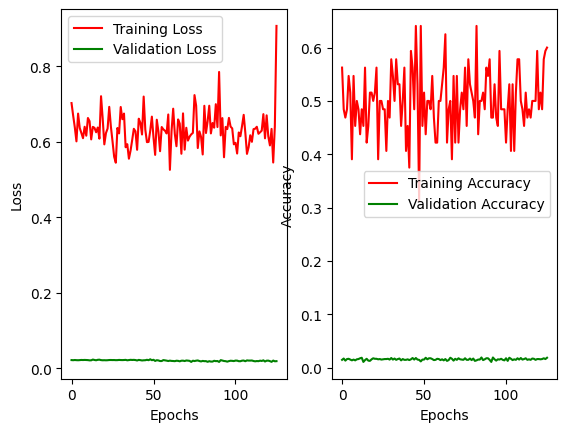

In [130]:
plt.subplot(121)

plt.plot(range(len(trn_losses)), trn_losses, label='Training Loss', color='red')
# plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='green')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(range(len(trn_accuracies)), trn_accuracies, label='Training Accuracy', color='red')
# plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
